# Dimension Reduction for Image Data

Lixun Zhang  
Nov 10, 2015

# 1 Introduction

The purpose of this notebook is to demonstrate how to conduct dimension reduction for image data in Azure ML notebook. 

Two advantages of dimension reduction are:
  * data compression: reduce the storage requirements and speed up learning algorithm
  * data visualization: lower dimension data are easier to visualize than higher dimension ones

## 2 Data
### 2.1 Data Source
The dataset used in his example is from [Labeled Faces in the Wild][data link]. I first downloaded the "subset of images - people with name starting with A" to my computer and then uploaded the pictures to an Azure blob storage. More information about Azure Blob storage can be found [here][blob link].  

### 2.2 Read and Prepare Data
The following lines of code read the data from my blob storage into the current session.

[data link]: http://vis-www.cs.umass.edu/lfw/#download
[blob link]: https://azure.microsoft.com/en-us/documentation/articles/storage-introduction/

In [1]:
import os
from azure.storage.blob import BlobService
from numpy.random import RandomState
import numpy as np
from PIL import Image
from time import time

image_shape = (64, 64)

blob_service = BlobService(account_name="tobedeleted", 
    account_key="kZYxDd0fxWZ0pov2NmanP3wBQdvsh1AtdGvOJFDKJuET\
    Jx/rXICs365dOAQ5iFM5UKXKyRBliQrCwOayjbm42A==")

# list all files in a blob storage
blobs = []
marker = None
mylist = []
dirname = os.getcwd()
while True:
    batch = blob_service.list_blobs('test', marker=marker)
    blobs.extend(batch)
    if not batch.next_marker:
        break
    marker = batch.next_marker

# convert images to black and white, resize, and save data to list of arrays
for blob in blobs:
    blob_service.get_blob_to_path('test', blob.name, blob.name)
    img = Image.open(os.path.join(dirname, blob.name))
    img3 = img.convert('L')
    img4 = img3.resize(image_shape)
    arr = np.array(img4)
    arr_list = arr.reshape(1, -1)[0]
    mylist.append(arr_list)
    os.remove(os.path.join(dirname, blob.name))

myarray = np.array(mylist)
n_samples, n_features = myarray.shape

# global centering
myarray_centered = myarray - myarray.mean(axis=0)

# local centering
myarray_centered -= myarray_centered.mean(axis=1).reshape(n_samples, -1)


## 3 Dimension Reduction
The sklearn package has several decomposition methods and we'll use MiniBatchSparsePCA here.

In [2]:
n_row, n_col = 10, 10
n_components = n_row * n_col

from sklearn import decomposition

name = "Non-negative components - NMF"
estimator = decomposition.NMF(n_components=n_components, 
                              init='nndsvda', beta=1.0,
                       tol=5e-3, sparseness='components')
data = myarray
                                   
name = 'Eigenfaces - RandomizedPCA'
estimator = decomposition.RandomizedPCA(n_components=n_components, 
                                        whiten=True)          
data = myarray_centered

rng = RandomState(0)

name = 'Sparse compomponents - MiniBatchSparsePCA'
estimator = decomposition.MiniBatchSparsePCA(n_components=n_components, 
                                      alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng)
data = myarray_centered

The following function will be used to plot images.

In [3]:
def plot_images(title, images, n_row=2, n_col=3):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.suptitle(title, fontsize=16)
    for j, img in enumerate(images):
        plt.subplot(n_row, n_col, j + 1)
        vmax = max(img.max(), -img.min())
        plt.imshow(img.reshape(image_shape), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(left = 0.05, bottom = 0.02, right = 0.95, top = 0.92, wspace = 0.02, hspace = 0.02)

The selected number of components are extracted and printed using the following code.

Extracting the top 100 Sparse compomponents - MiniBatchSparsePCA
done in 78.3s


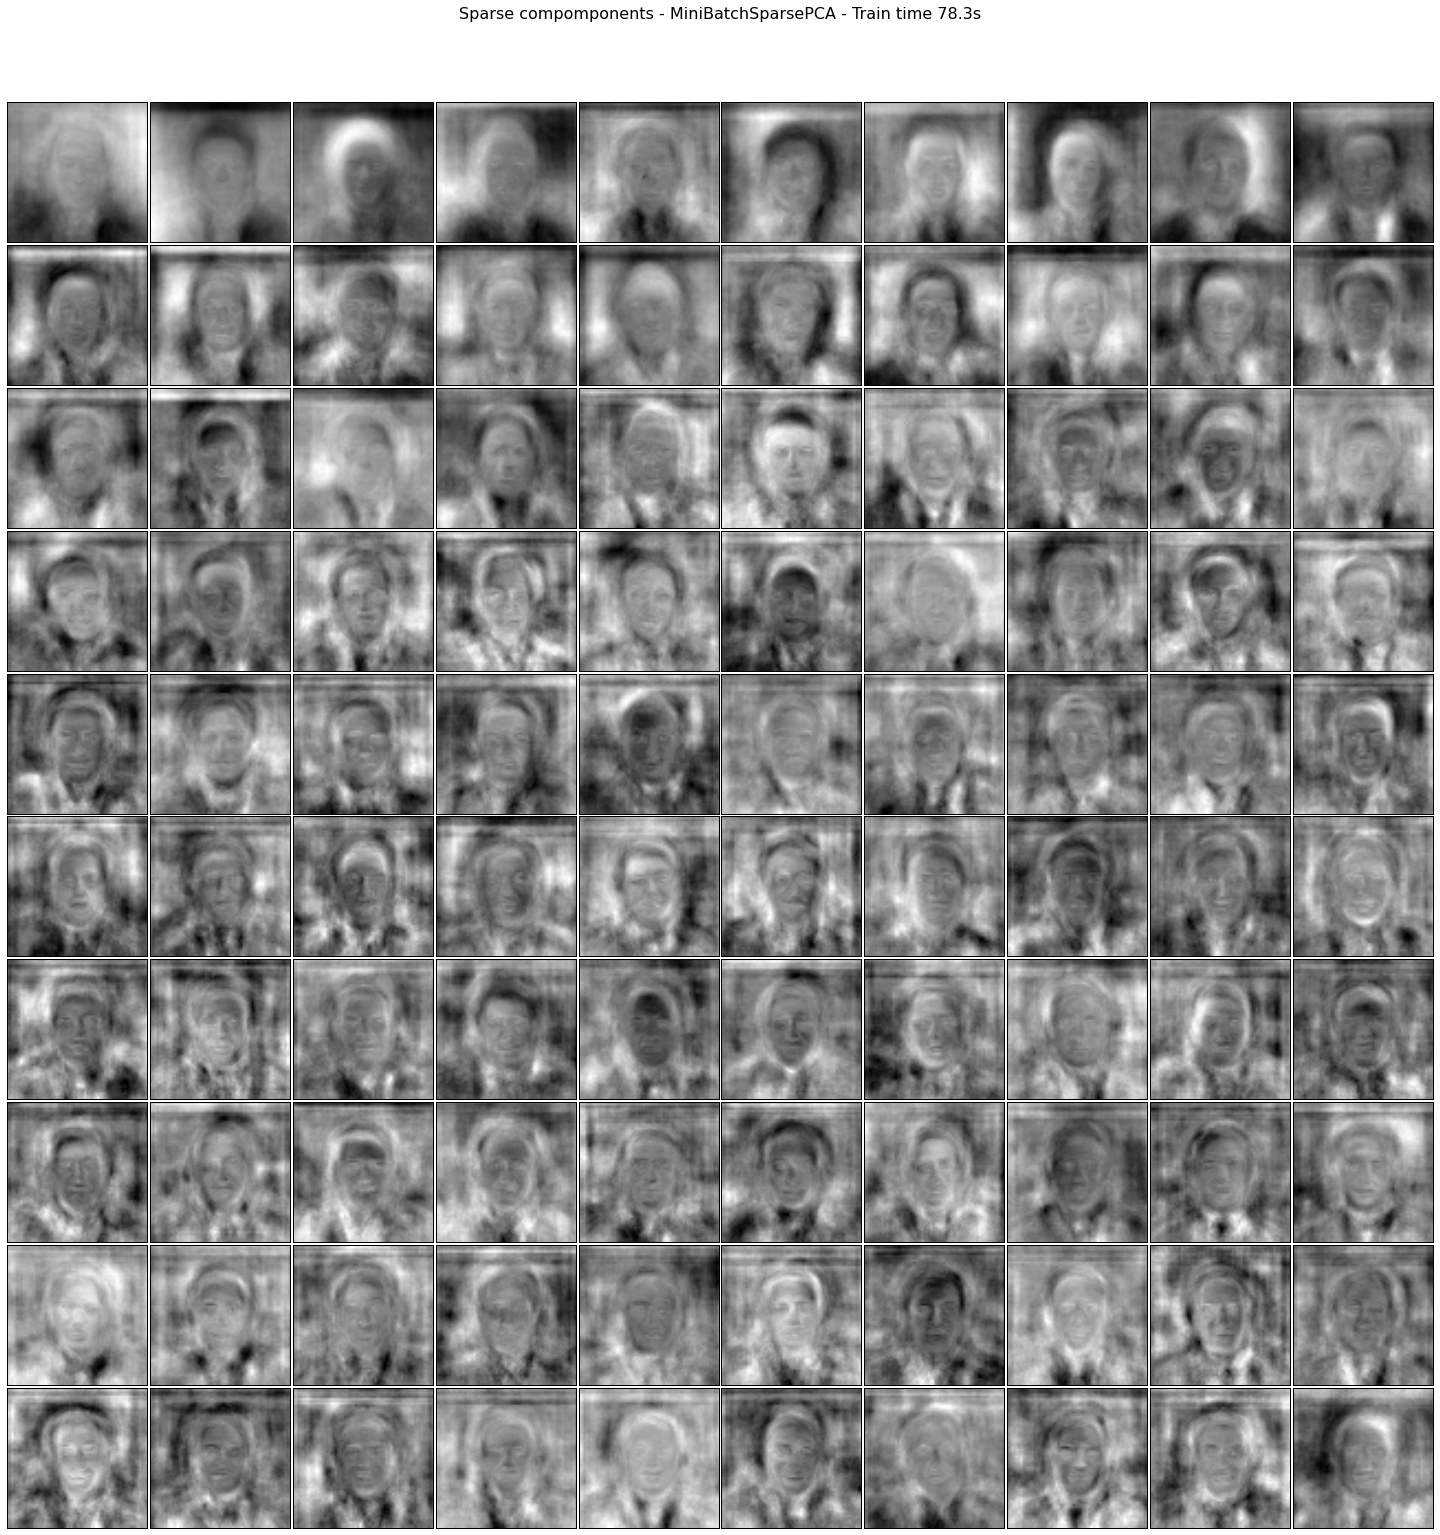

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

print("Extracting the top {0:d} {1:s}".format(n_components, name))
t0 = time()
W = estimator.fit_transform(data)
H = estimator.components_
train_time = (time() - t0)
print("done in {0:0.1f}s".format(train_time))
components_ = estimator.components_

#%% plot the components
plot_images('{0:s} - Train time {1:0.1f}s'.format(name, train_time),
             components_[:n_components], n_col=n_col, n_row=n_row)

plt.show()

#### 4 Image Recovery
We can use the saved components to recover images. The following code compares the original pictures with the recovered ones for 6 samples.

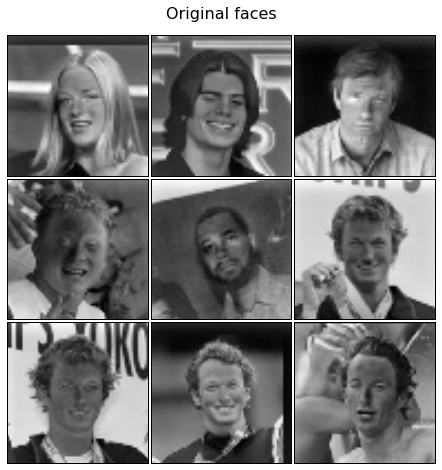

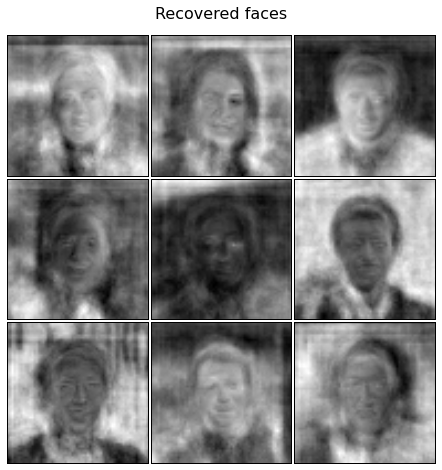

In [5]:
#%% recover images
V_approx = np.dot(W, H)

n_row_person = 3
n_col_person = 3
n_person = n_row_person * n_col_person
plot_images("Original faces", data[:n_person], n_row = n_row_person,
            n_col = n_col_person)
plot_images("Recovered faces", V_approx[:n_person], n_row = n_row_person,
            n_col = n_col_person)
 

## 5 Discussion
To further illustrate how dimension reduction helps data compression, consider the following example. Support we had 10,000 pictures, each having 4,096 pixel values. Storing the original data would need 40,960,000 data points. If we extracted the top 100 components, we would store 409,600 (=100 \* 4,096) values for these components and need 1,000,000 (=10,000 \* 100) for the pictures. So with dimension reduction we now just need 1,409,600 data points. This means a reduction of approximately 97% in storage space.

If there are new data points, we can use the following code to extract the W matrix. This can be useful when, for example, the components are used in supervised machine learning as predictors and we want to make predictions for new data points.

In [6]:
# calculate the W matrix for new data, using origianl data for illustration
data_new = data
W_new = estimator.transform(data_new)

---  
Created by a Microsoft Employee.  
Copyright © Microsoft. All Rights Reserved.